# a notebook to figure out some plotting stuff
- for example, a strikezone view of the pitches when they cross the plate
- 3d trails if I can figure that out ( I think there are polynomials in the baseball savant endpoint here: https://baseballsavant.mlb.com/gf?game_pk=) 

In [44]:
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from pybaseball import statcast_batter, spraychart

import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
# this defaults to yesterday
#end_dt = '2023-03-30'
# remember this will be utc 
end_dt = str(datetime.date.today() + datetime.timedelta(days=-1))


df = statcast(start_dt=end_dt, end_dt=end_dt)

print(df.shape)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.16s/it]

(1428, 92)


In [180]:
df.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1047,SL,2023-03-31,84.5,3.41,5.29,"Puk, A.J.",643446,640462,field_out,hit_into_play,...,2,1,2,1,2,Strategic,Standard,286,0.035,-0.013
1068,SL,2023-03-31,84.1,3.4,5.38,"Puk, A.J.",643446,640462,NaN,foul,...,2,1,2,1,2,Standard,Standard,280,0.0,-0.031
1139,SL,2023-03-31,83.7,3.39,5.32,"Puk, A.J.",643446,640462,NaN,foul,...,2,1,2,1,2,Standard,Standard,241,0.0,-0.02
1158,FF,2023-03-31,96.3,3.3,5.46,"Puk, A.J.",592192,640462,strikeout,swinging_strike,...,2,1,2,1,2,Standard,Standard,129,0.052,-0.093
1185,SL,2023-03-31,84.0,3.4,5.38,"Puk, A.J.",592192,640462,NaN,swinging_strike,...,2,1,2,1,2,Strategic,Standard,279,0.0,-0.065
1260,SL,2023-03-31,83.7,3.47,5.36,"Puk, A.J.",592192,640462,NaN,called_strike,...,2,1,2,1,2,Strategic,Standard,276,0.0,-0.038
1289,FF,2023-03-31,95.1,3.31,5.51,"Puk, A.J.",624413,640462,home_run,hit_into_play,...,2,1,2,1,2,Standard,Standard,123,-0.053,1.0
1320,FF,2023-03-31,96.2,3.36,5.5,"Puk, A.J.",596019,640462,strikeout,swinging_strike,...,2,0,2,0,2,Standard,Standard,125,0.037,-0.092
1353,FF,2023-03-31,95.7,3.39,5.47,"Puk, A.J.",596019,640462,NaN,swinging_strike,...,2,0,2,0,2,Standard,Standard,130,0.0,-0.068
1423,SL,2023-03-31,84.8,3.49,5.33,"Puk, A.J.",596019,640462,NaN,called_strike,...,2,0,2,0,2,Standard,Standard,247,0.0,-0.062


In [184]:
df.pitcher.value_counts()

607259    101
458681     96
592662     91
666200     91
669160     84
656849     84
664299     82
607536     74
518876     74
683769     70
686753     66
623167     66
641627     35
472610     26
681911     22
669212     22
543272     21
606160     20
488984     19
572955     19
660853     19
680704     18
614179     18
608665     15
657571     15
608638     14
657612     14
661527     13
543518     13
608718     13
664208     13
650556     12
518617     12
595928     12
571670     11
663986     11
661403     10
605177     10
640462     10
682171      7
669424      4
623465      1
Name: pitcher, dtype: Int64

In [4]:
a_pitch = df.loc[1]

In [5]:
a_pitch

pitch_type                                CH
game_date                2023-03-31 00:00:00
release_speed                           80.2
release_pos_x                          -1.76
release_pos_z                           6.23
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                246
delta_home_win_exp                       0.0
delta_run_exp                            0.0
Name: 1, Length: 92, dtype: object

In [6]:
a_pitch.game_pk

718766

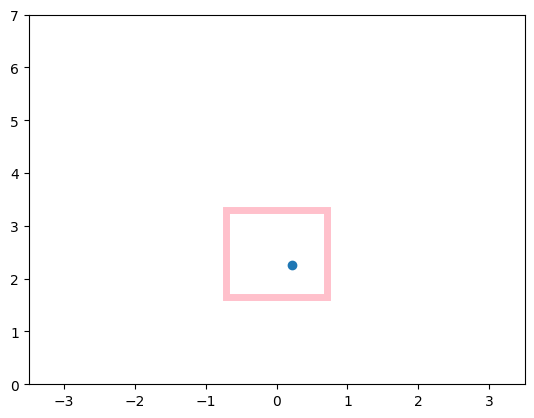

In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot(a_pitch["plate_x"], a_pitch["plate_z"], 'o')

#add rectangle to plot
ax.add_patch(Rectangle((-0.71, a_pitch["sz_bot"]), 2*0.71, a_pitch["sz_top"] - a_pitch["sz_bot"],
             edgecolor = 'pink',
             facecolor = 'blue',
             fill=False,
             lw=5))


ax.set_xlim(-3.5, 3.5)
ax.set_ylim(0, 7)

#display plot
plt.show()

In [244]:
pitch_abbreviation_to_name = {
    "FF" : "4-Seam Fastball",
    "CU" : "Curveball",
    "CH" : "Changeup",
    "FC" : "Cutter",
    "EP" : "Eephus",
    "FO" : "Forkball",
    "KN" : "Knuckleball",
    "KC" : "Knuckle-curve",
    "SC" : "Screwball",
    "SI" : "Sinker",
    "SL" : "Slider",
    "FS" : "Splitter",
    "FT" : "2-Seam Fastball",
    "ST" : "Sweeper",
    "SV" : "Slurve"
}

In [245]:
# Do this again, but for all pitches

all_pitches = df[df.pitcher == 607259]
# here is the game that he pitched in https://www.youtube.com/watch?v=r5-DFUnWevY

In [243]:
all_pitches.pitch_type.value_counts()

CH    31
FF    20
SI    18
CU    17
FC    15
Name: pitch_type, dtype: int64

In [68]:
all_pitches.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

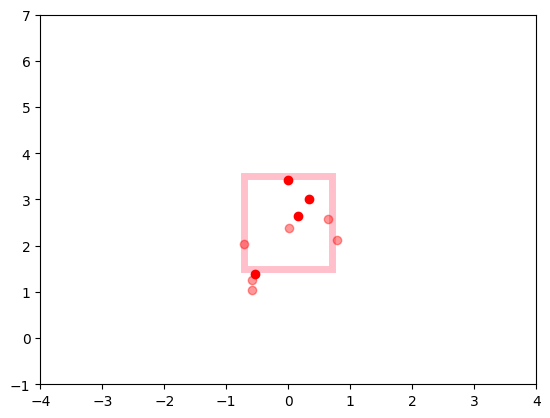

In [13]:
#define Matplotlib figure and axis
fig, ax = plt.subplots()

for row in all_pitches.iterrows():
    row = row[1]
    ax.plot(row["plate_x"],
            row["plate_z"],
            'o',
            alpha = 0.4 if pd.isna(row["events"]) else 1,
            color = "green" if row["description"] == "ball" else "red")

#add strike zone to plot
ax.add_patch(Rectangle((-0.71, 1.5), 2*0.71, 2,
             edgecolor = 'pink',
             facecolor = 'blue',
             fill=False,
             lw=5))

ax.set_xlim(-4, 4)
ax.set_ylim(-1, 7)


plt.show()

## Quick things to make this better
- turn into a function
- different colors for different pitch types
- draw a plate?
- markers that show speed and type
- maybe movement with like a empty circle, vector, filled circle


maybe make it infer which kind of plot to make?

In [299]:
def plot_strike_zone(pitch_df: pd.DataFrame, title: str = '', colorby: str = 'pitch_type', annotation: str = None) -> None:
    """
    Produces a pitches overlaid on a strike zone using statcast data
    
    Args:
        pitch_df: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        title: (str), default = ''
            Optional: Title of plot
        colorby: (str), default = 'pitch_type'
            Optional: Which category to color the mark with. 'pitch_type','pitcher', 'description' or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the pitches overlaid on the strike zone
    """
    
    
    # some things to auto adjust formatting
    # make the markers really visible when fewer pitches
    alpha_markers = min(0.8, 0.5 + 1 / pitch_df.shape[0])
    alpha_text = alpha_markers + 0.2
    
    # define Matplotlib figure and axis
    fig, ax = plt.subplots()

    # add home plate to plot 
    home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
    plate = Polygon(home_plate_coords,
                edgecolor = 'darkgray',
                facecolor = 'lightgray',
                lw = 2)
    ax.add_patch(plate)
    
    # add strike zone to plot. technically this can vary by batter
    # ignore that for now
    ax.add_patch(Rectangle((-0.71, 1.5), 2*0.71, 2,
                 edgecolor = 'lightgray',
                 fill=False,
                 lw=3))
    
    legend_title = ""
    color_label = ""
    
    # to avoid the SettingWithCopyWarning error
    sub_data = pitch_df.copy().reset_index(drop=True)
    
    if colorby == 'pitch_type':
        color_label = 'pitch_type'
        
        if not legend_title:
            legend_title = 'Pitch Type'
            
    elif colorby == 'description':
        values = sub_data.loc[:, 'description'].str.replace('_', ' ').str.title()
        sub_data.loc[:, 'desc'] = values
        color_label = 'desc'
        
        if not legend_title:
            legend_title = 'Pitch Description'
    elif colorby == 'pitcher':
        color_label = 'player_name'
        
        if not legend_title:
            legend_title = 'Pitcher'
            
    elif colorby == "events":
        # only things where something happened
        sub_data = sub_data[sub_data['events'].notna()]
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        
        if not legend_title:
            legend_title = 'Outcome'
    
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby
        
    scatters = []
    
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(ax.scatter(
            color_sub_data["plate_x"],
            color_sub_data['plate_z'],
            s = 10**2,
            label = pitch_abbreviation_to_name[color] if color_label == 'pitch_type' else color,
            alpha = alpha_markers
        ))

        
        # add an annotation at the center of the marker
        if annotation:
            for i, pitch_coord in zip(color_sub_data.index, zip(color_sub_data["plate_x"], color_sub_data['plate_z'])):
                label_formatted = color_sub_data.loc[i, annotation]
                label_formatted = label_formatted if not pd.isna(label_formatted) else ""
                
                if annotation in ["release_speed", "effective_speed", "launch_speed"] and label_formatted != "":
                    label_formatted = "{:.0f}".format(label_formatted)
                
                ax.annotate(label_formatted,
                            pitch_coord,
                            size = 7,
                            ha = 'center',
                            va = 'center',
                            alpha = alpha_text)

    ax.set_xlim(-4, 4)
    ax.set_ylim(-1.5, 7)
    
    plt.axis('off')

    plt.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)

    plt.show()
    
    

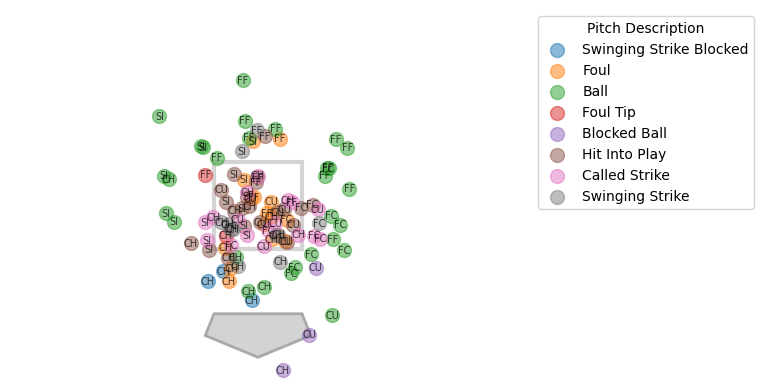

In [289]:
all_pitches = df[df["pitcher"] == 607259]

plot_strike_zone(all_pitches, colorby = 'description', annotation = "pitch_type")

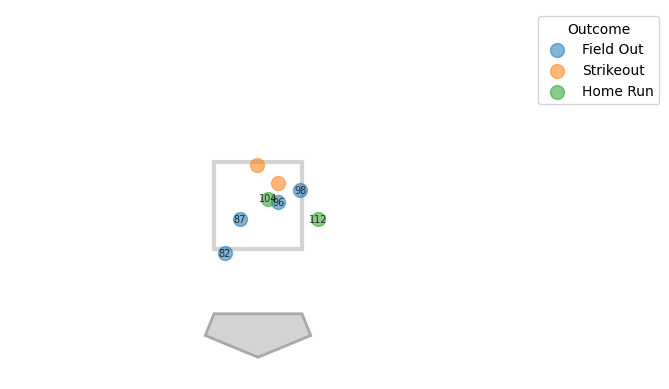

In [301]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "launch_speed")

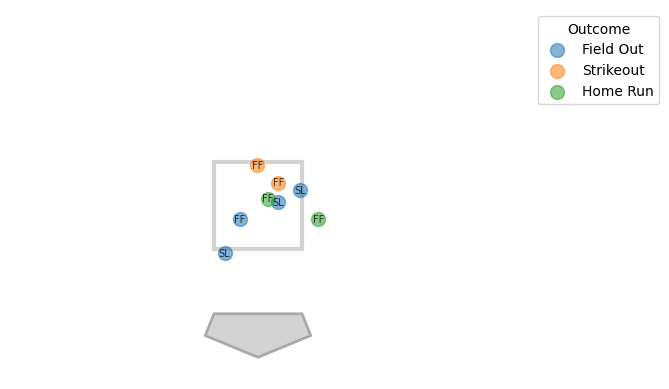

In [302]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "pitch_type")

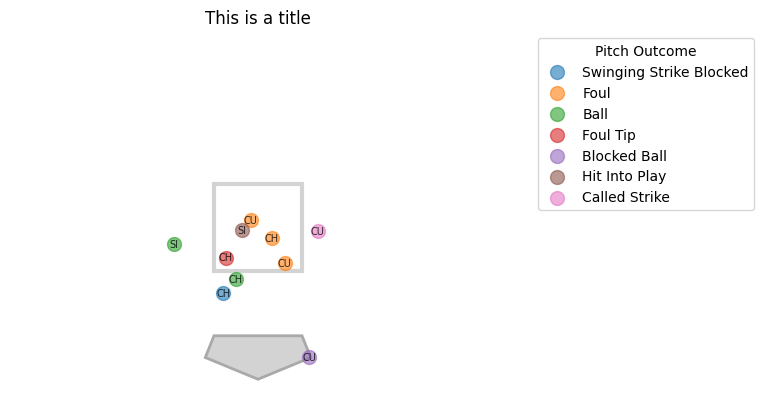

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'This is a title'}>)

In [263]:
plot_strike_zone(all_pitches.iloc[:10], title = "This is a title", colorby = 'description', annotation = "pitch_type")

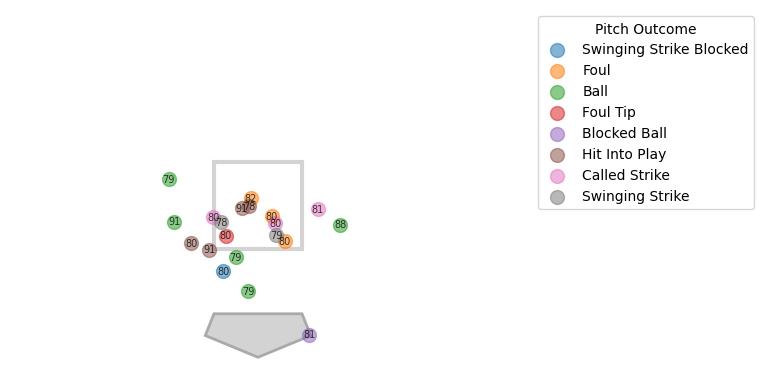

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [249]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed")

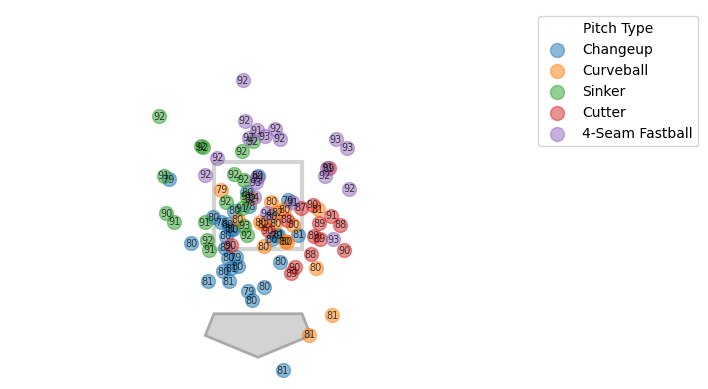

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [250]:
plot_strike_zone(all_pitches, colorby = 'pitch_type', annotation = "release_speed")

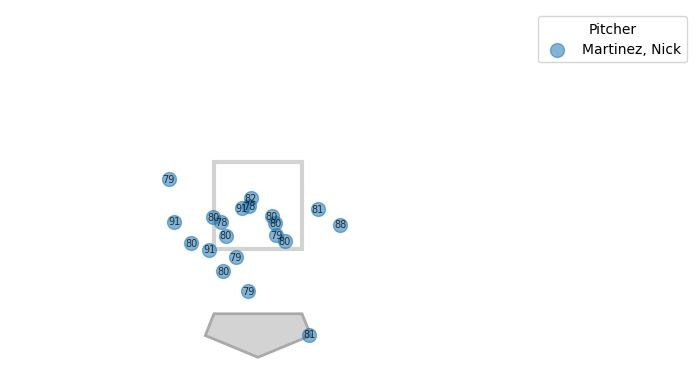

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [259]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'pitcher', annotation = "release_speed")

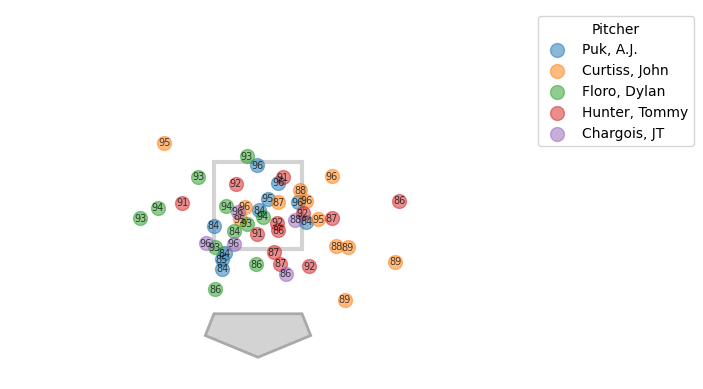

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [260]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "release_speed")

In [267]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "launch_speed")